In [7]:
from quantum_electron import FullModel, PotentialVisualization
from quantum_electron.utils import xy2r, r2xy, density_from_positions
import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import elementary_charge as qe, epsilon_0 as eps0, electron_mass as me
from alive_progress import alive_bar

from zeroheliumkit.fem import FieldAnalyzer
import scipy

# Load the potential data

In [22]:
phi = FieldAnalyzer(("fem_data/long_channel.txt", 'phi', '2Dmap'))

potential_dict = phi.phi
channel_length = 50
micron = 1e-6

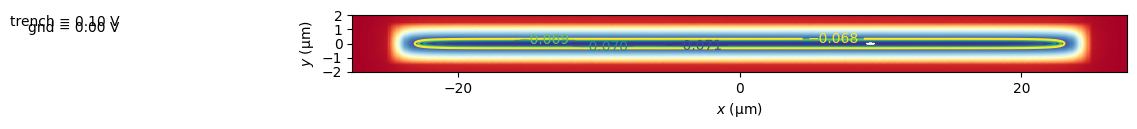

In [43]:
voltages = {"trench" : 0.1, "gnd" : 0.0}

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
p = PotentialVisualization(potential_dict, voltages)
p.plot_potential_energy(ax=ax, dxdy=(55, 4))

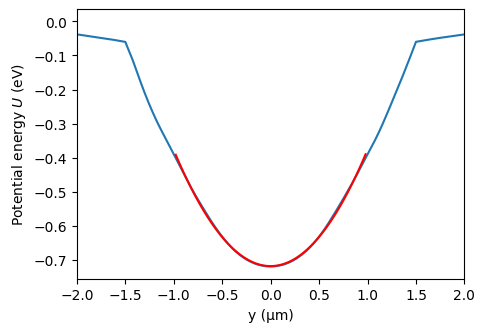

In [83]:
potential_slice = -potential_dict['trench'][500, :]

fig = plt.figure(figsize=(5, 3.5))
plt.plot(potential_dict['ylist'], potential_slice)
plt.xlim(-2, 2)
plt.xlabel(f"y ({chr(956)}m)")
plt.ylabel("Potential energy $U$ (eV)")

def quadratic_func(x, *p):
    a, b, c = p
    return a*x**2 + b*x + c

fitdomain = (-1, 1) # microns
selection = np.where((potential_dict['ylist'] > fitdomain[0]) & (potential_dict['ylist'] < fitdomain[-1]))[0]
xdata = potential_dict['ylist'][selection]
ydata = potential_slice[selection]

popt, pcov = scipy.optimize.curve_fit(quadratic_func, xdata, ydata, p0=(1, 1, 1))

plt.plot(xdata, quadratic_func(xdata, *popt), '-r')
quadratic_coefficient = popt[0] / micron ** 2

# Adding electrons

385


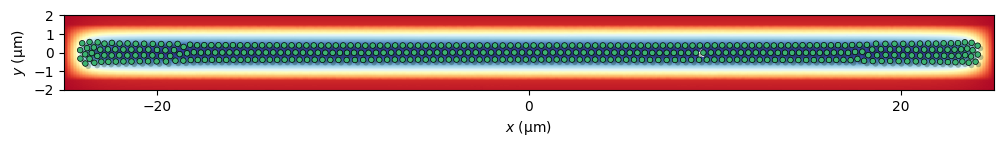

In [111]:
n_electrons = 400

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*10, max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
fm.remove_unbound_electrons = True

# Create a rectangular initial condition
n_rows = 1
init_x = np.tile(np.linspace(-channel_length/2+1.5, channel_length/2-1.5, n_electrons // n_rows), n_rows) * micron
init_y = np.repeat(np.linspace(-.8, 8, n_rows), n_electrons // n_rows) * micron
initial_condition = xy2r(init_x, init_y)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)
final_x, final_y = r2xy(res['x'])

fm.plot_potential_energy(ax=ax, dxdy=(channel_length, 4), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax, marker_size=4)

print(len(final_x))

In [112]:
density_from_positions(final_x, final_y) / 1e13

0.8301841797208297

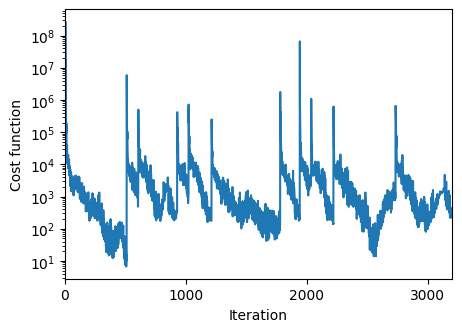

In [113]:
fm.plot_convergence()

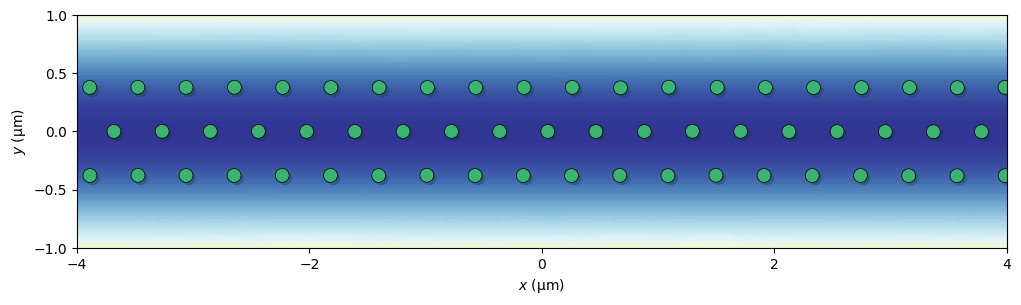

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
fm.plot_potential_energy(ax=ax, dxdy=(8, 2), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax)

# Eigenmodes

In [115]:
print("Trap curvature for electrons is", 1 / (2 * np.pi * 1e9) * np.sqrt(2 * qe * quadratic_coefficient * voltages['trench'] / me), "GHz")

Trap curvature for electrons is 17.417221585763265 GHz


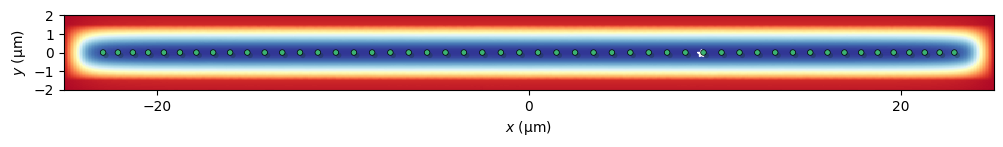

In [237]:
n_electrons = 50
n_plots = 5

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[10.0]*5, max_x_displacement=0.25e-6, max_y_displacement=0.25e-6)
fm.remove_unbound_electrons = True

# Create a rectangular initial condition
n_rows = 1
init_x = np.tile(np.linspace(-channel_length/2+1.5, channel_length/2-1.5, n_electrons // n_rows), n_rows) * micron
init_y = np.repeat(np.linspace(-.8, 8, n_rows), n_electrons // n_rows) * micron
initial_condition = xy2r(init_x, init_y)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)
final_x, final_y = r2xy(res['x'])

fm.plot_potential_energy(ax=ax, dxdy=(channel_length, 4), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax, marker_size=4)

# Feed this into the model
res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=initial_condition, verbose=False)



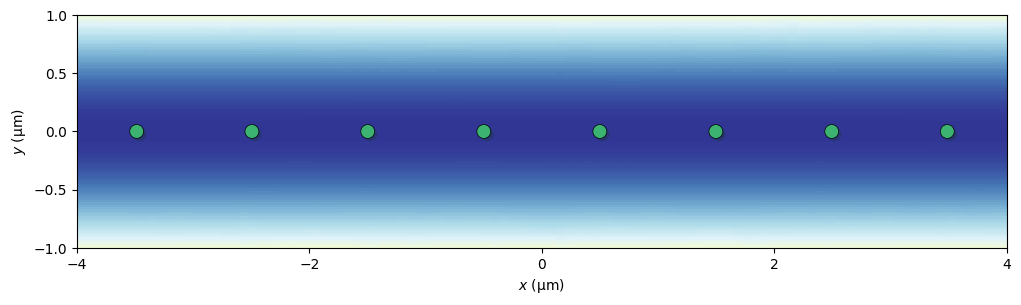

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
fm.plot_potential_energy(ax=ax, dxdy=(8, 2), print_voltages=False, plot_contours=False)
fm.plot_electron_positions(res, ax=ax)

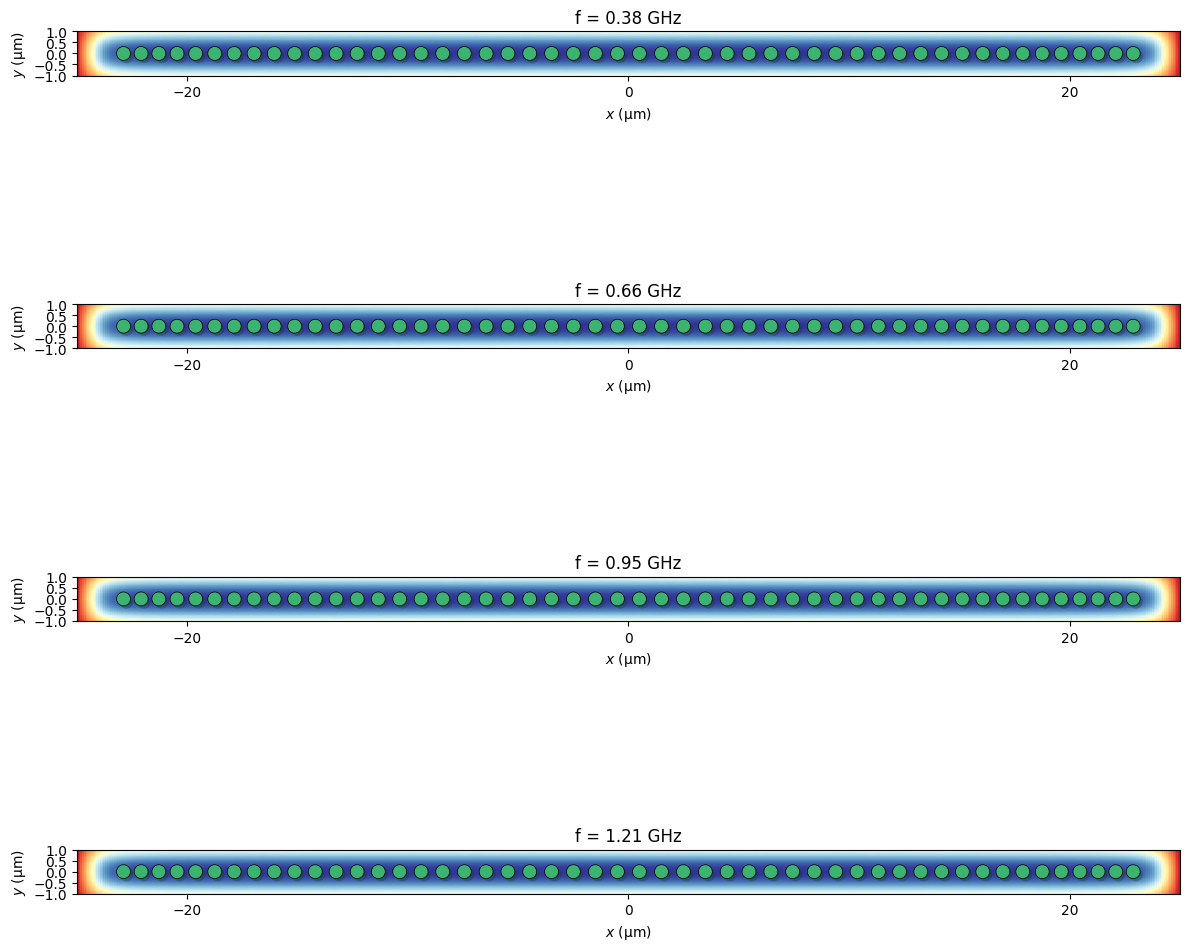

In [239]:
n_plots = 4

fig, ax = plt.subplots(n_plots, 1, figsize=(12, 3*n_plots))
fm.set_rf_interpolator(rf_electrode_labels=['trench'])

for n in range(n_plots):
    fm.plot_potential_energy(ax=ax[n], dxdy=(channel_length, 2), print_voltages=False, plot_contours=False)
    # fm.plot_electron_positions(res, ax=ax[n])

    # Solve the equations of motion
    K, M = fm.setup_eom(res['x'])
    efreqs, evecs = fm.solve_eom(K, M, sort_by_cavity_participation=False)

    # fm.plot_eigenvector(res['x'], evecs[:, n])

    ax[n].set_title(f"f = {efreqs[n]/1e9:.2f} GHz")
    
fig.tight_layout()
anim = fm.animate_eigenvectors(fig, ax, evecs.T, res['x'])

In [240]:
fm.show_animation(anim)

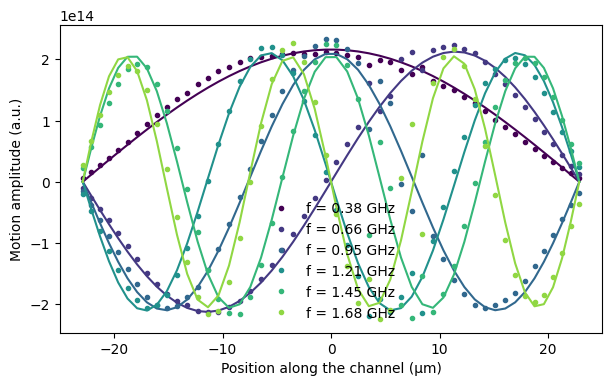

In [243]:
m = len(final_x)
max_plots = 6
max_modes = m - 15
fitparams = np.zeros((max_modes, 2))

fig = plt.figure(figsize=(7, 4.))
for mode_idx in range(max_modes):
    mode_profile = evecs.T[mode_idx][1:m+1]

    def sine_func(x, *p):
        A, n = p
        return A * np.sin(np.round(n) * np.pi * (x - chain_length/2) / chain_length)

    order = np.argsort(final_x)
    xdata = final_x[order]
    ydata = mode_profile[order]

    popt, pcov = scipy.optimize.curve_fit(sine_func, xdata, ydata, p0=(np.max(ydata), mode_idx+1))

    if mode_idx < max_plots:
        plt.plot(xdata / micron, ydata, '.', color=plt.cm.viridis(mode_idx / max_plots), label=f"f = {efreqs[mode_idx]/1e9:.2f} GHz")
        plt.plot(xdata / micron, sine_func(xdata, *popt), '-', color=plt.cm.viridis(mode_idx / max_plots))

    fitparams[mode_idx, :] = popt
        
plus_minus = np.sign(fitparams[:, 0])
wave_vectors = plus_minus * fitparams[:, 1] * np.pi / chain_length

plt.xlim(-channel_length/2, channel_length/2)
plt.xlabel(f"Position along the channel ({chr(956)}m)")
plt.ylabel("Motion amplitude (a.u.)")
plt.legend(loc=0, frameon=False)

In [244]:
chain_length = np.max(final_x) - np.min(final_x)
a = chain_length / (m+1)

omega_zero = np.sqrt((qe ** 2 / (4 * np.pi * eps0 * me * a ** 3))) / (2 * np.pi)

Text(0, 0.5, 'Normalized frequency $ω / ω_0$')

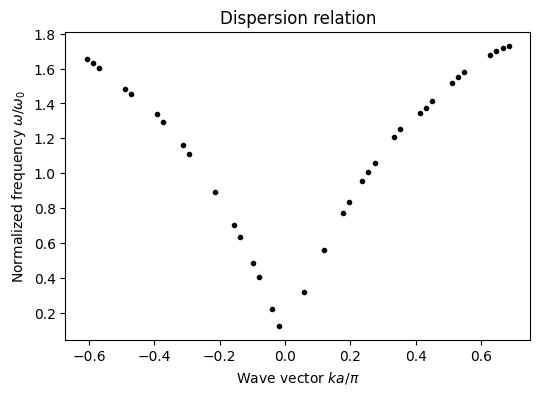

In [245]:
fig = plt.figure(figsize=(6., 4.))

for k_idx in range(m-20):
    k = k_idx * np.pi / chain_length

plt.plot(wave_vectors * a / np.pi, efreqs[:len(wave_vectors)] / omega_zero, '.k')

# x = np.linspace(-1, 1)
# plt.plot(x, np.sqrt(4 * np.sin(x * np.pi/2) ** 2))

plt.title("Dispersion relation")
plt.xlabel("Wave vector $k a / π$")
plt.ylabel("Normalized frequency $ω / ω_0$")

In [200]:
xi, yi = r2xy(res['x'])
n_s = density_from_positions(xi, yi)
print(f"Density = {n_s:.2e} m^-2")

Density = 3.68e+12 m^-2


In [204]:
k = np.pi / chain_length

w_e = 2 * np.max(final_y)
channel_depth = 1e-6

F_x = 1 #np.tanh(k * (channel_width - w_e)) + np.tanh(k * channel_depth)

f_theory = np.sqrt(n_s * qe ** 2 * np.sqrt(k ** 2 * F_x) / (2 * eps0 * me)) / (2 * np.pi)

print(f_theory / 1e9)

3.1579675640665066


In [205]:
a = 2e-6 / 6.5
np.sqrt(4 * (2 * qe ** 2 / (4 * np.pi * eps0 * me * a ** 3))) / (2 * np.pi * 1e9)

41.97365278052221

In [203]:
4 * np.pi * 1e12 * qe ** 2 * np.pi / 1e-2 / me

111247824.9215119

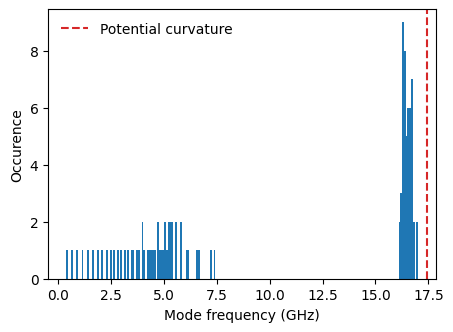

In [246]:
trap_curvature = 1 / (2 * np.pi * 1e9) * np.sqrt(2 * qe * voltages['trench'] * quadratic_coefficient / me)

fig = plt.figure(figsize=(5., 3.5))
plt.hist(efreqs/1e9, bins=200)
plt.axvline(trap_curvature, linestyle='--', color='tab:red', label="Potential curvature")
plt.xlabel("Mode frequency (GHz)")
plt.ylabel("Occurence")

plt.legend(loc=0, frameon=False)